<a href="https://colab.research.google.com/github/SeanKski/AnomalyDetection/blob/master/Anomalous_Feature_Detection_with_Delta_Anomaly_Score_using_Toy_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## External internal thoughts

What does it mean when when sklearn says anamoly score is opposite of what is in the paper?
* The paper states an $0 \geq a_{score} \leq 1$ where $a_{score}$ is more anamolous as it approaches 1
* So does this mean that the sklearn anamoly score is more anamolous the closer to 0? That doesn't support what we are seeing in the code
* Oh, I think they mean the mathematical opposite, i.e. the negative

Would it be better to create an isolation forest for each feature? 
* That way 



---





#Using Delta Anomaly Score for Anomalous Feature Detection. 


Setting up the enviroment

In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#Setting up the random state
rng = np.random.RandomState(42)
%matplotlib inline

## Setting up user functions

In [0]:
def make_scatter(X, labels, legend=False):
  """Takes in a X with shape (n,2) and labels shape(n,1) and returns a
  scatter plot"""
  if len(labels.shape) == 1:
    labels = labels.reshape(-1,1)
  scatter = plt.scatter(X[:,0], X[:,1], c=labels[:,0])
  if legend:
    plt.legend(*scatter.legend_elements())
  return scatter

## Setting up toy data
Creating 3 n-Dimensional classes where for each class, the anomolous features are created by replacing the values of the last $k$ features of anomalous samples with uniform noise, where $k$ is the number of anomolous features. 

In [0]:
def make_toy_data(n_features=6, n_a_features=2, n_samples=500, 
                  sample_contamination_level=.3, random_state=None):
  """
  Makes the classification data
  note: the anamolous features will always be the last features
  
  Parameters
  ----
  n_features: ...
  n_id_samples: num of in-distribution samples
  sample_contamination_level: the percent of samples to be contaminated
  feature_contamination_level: ...

  Returns
  ----
  X_all: The X data including non_a and a samples
  X_id: Just the id samples
  X_a: Just the a samples
  y_all: The labels for the samples +1=id, -1 =a
  y_id: ...
  y_a: ...
  """
  n_a_samples = int(sample_contamination_level * n_samples)  # a=anomalous
  n_id_samples = n_samples - n_a_samples
  # generating the n-d data
  X_in, y_in = datasets.make_classification(n_samples=n_samples, 
                n_features=n_features, n_informative=n_features, 
                n_redundant=0, n_repeated=0, n_classes=1,shuffle=True,
                 class_sep=3, random_state=random_state)
  # setting the n_a_features to uniform noise for a_samples
  X_in[n_id_samples:,n_features-n_a_features:] = \
        np.random.uniform(-10,10, size=(n_a_samples, n_a_features))


  X_all = X_in
  X_id = X_all[:n_id_samples,:]
  X_a = X_in[n_id_samples:,:]
  y_all = np.full_like(y_in, 1)
  y_all[n_id_samples:] = -1
  y_id = y_all[:n_id_samples]
  y_a = y_all[n_id_samples:]
  return X_all, X_id, X_a, y_all, y_id, y_a, n_features

In [0]:
# making the data
X_all, X_id, X_a, y_all, y_id, y_a, n_features = \
  make_toy_data(n_features=5, n_a_features=2, random_state=rng)

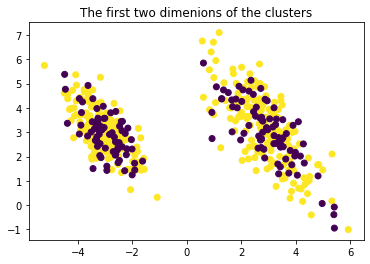

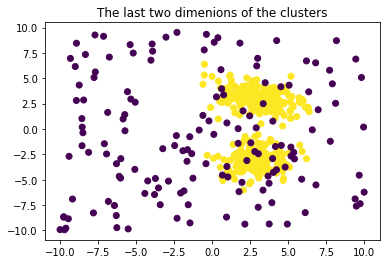

In [0]:
# plotting
plt.title('The first two dimenions of the clusters')
scatter = make_scatter(X_all, y_all)
plt.show()
if n_features > 2:
  plt.title('The last two dimenions of the clusters')
  scatter = make_scatter(X_all[:,-2:]
            ,y_all)
plt.show()

## Training and Testing the IF model


In [0]:
# Creating train, test split
X_train, X_test, y_train, y_test = \
  train_test_split(X_all, y_all, train_size=.8, random_state=rng)

In [0]:
# Training and fitting the IF model
IF = IsolationForest(n_jobs=-1, random_state=rng).fit(X_train)
# Gathering predicitons
y_pred_train = IF.predict(X_train)
y_pred_test = IF.predict(X_test)
y_pred_a = IF.predict(X_a)

In [0]:
IF.score_samples(X_a).mean()

-0.5068258394626894

In [0]:
IF.score_samples(X_id).mean()

-0.42974136664298757

## Roc Calulations

In [0]:
roc_auc_result = roc_auc_score(y_test, y_pred_test)
print(f'ROC AUC score: {roc_auc_result}')

ROC AUC score: 0.7895220588235294


## Plotting the raw IF Predicitons

The first two dimensions of the data:


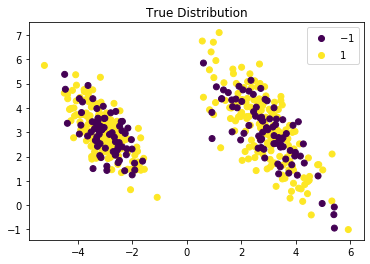

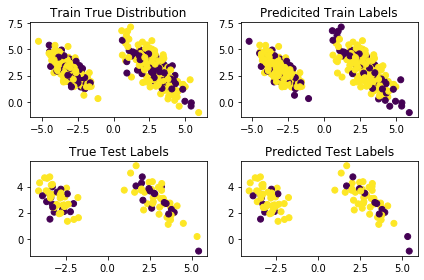

In [0]:
# Plotting predicitons
print('The first two dimensions of the data:')
plt.title('True Distribution')
scatter = make_scatter(X_all, y_all, legend=True)
plt.show()

plt.subplot(221)
plt.title('Train True Distribution')
scatter = make_scatter(X_train, y_train)
plt.subplot(222)
plt.title('Predicited Train Labels')
scatter = make_scatter(X_train, y_pred_train)
plt.subplot(223)
plt.title('True Test Labels')
scatter = make_scatter(X_test, y_test)
plt.subplot(224)
plt.title('Predicted Test Labels')
scatter = make_scatter(X_test, y_pred_test)
plt.tight_layout()
plt.show()

## Setting up delta anomaly score
This is a $\mathbb{R}^{nxp}$ matrix where $n$ is a the number of samples and $p$ is the number of features per samples. Each entry in the matrix is the difference in anomaly score for sample $n$ with all $p$ features and the sample $i$ with all $p$ features except for the $j^{th}$ feature. i.e. ($(m)_{i,j} = A(\mathbf{X}_i) - A(\mathbf{X}_{ij})$, where $\mathbf{X}_{ij}$ is the $i^{th}$ sample with the $j^{th}$ feature being treated as missing)

# Temp: For now we will just be imputing the $j^{th}$ feature value with the mean of that feature as seen in the training data. 


In [0]:
def calc_delta_a_score(X_train, X_test, IF):
  # Computing the feature means for X_train
  X_feat_means = np.mean(X_train, axis=0)

  #Creating delta anaomaly score matrix
  delta_a_score_M = np.empty_like(X_test)
  a_score_org_vect = IF.score_samples(X_test)  # a 1-d array of anomaly scores 
  for i_idx, X_i in enumerate(X_test):
    for j_idx, j in enumerate(X_i):
      X_i[j_idx] = X_feat_means[j_idx]
      delta_a_score_M[i_idx, j_idx] = a_score_org_vect[i_idx] - \
          IF.score_samples(X_i.reshape(1,-1))
      X_i[j_idx] = j  # setting the j feature value back to normal
  return delta_a_score_M

In [0]:
# get a feature average anamoloy score
delta_a_score_M = calc_delta_a_score(X_train, X_test, IF)
X_feat_a_score_avg = np.mean(delta_a_score_M, axis=0)
X_feat_a_score_norm = np.linalg.norm(delta_a_score_M, axis=0)
print(f'The means of the anomaly score of each feature: {X_feat_a_score_avg}\n\
The norm of the anomaly score of each feature: {X_feat_a_score_norm}')

The means of the anomaly score of each feature: [ 0.02112144 -0.01087098 -0.01279197 -0.01623434  0.00288457]
The norm of the anomaly score of each feature: [0.26180467 0.17395192 0.21414939 0.36106699 0.21361481]


In [0]:
# plotting the above two things with respect to contamination level
levels = 50
contam_levels = np.linspace(.05, .7, levels)
feat_a_score_avg_M = np.empty((levels, n_features))
feat_a_score_norm_M = np.empty((levels, n_features))

start_time = time.time()
random_state = 10  # change?
for i_idx, k in enumerate(contam_levels):
  X_all, X_id, X_a, y_all, y_id, y_a, n_features = \
  make_toy_data(n_features=5, n_a_features=2, sample_contamination_level=k,
                random_state=10)
  X_train, X_test, y_train, y_test = \
  train_test_split(X_all, y_all, train_size=.8, random_state=10)
  IF = IsolationForest(n_jobs=-1, random_state=10).fit(X_train)
  delta_a_score_M = calc_delta_a_score(X_train, X_test, IF)
  feat_a_score_avg_M[i_idx] = np.mean(delta_a_score_M, axis=0)
  feat_a_score_norm_M[i_idx] = np.linalg.norm(delta_a_score_M, axis=0)

print(f'Wallclock time: {(time.time() - start_time) / 60} (min)')

#saving output to txt file
np.savetxt('/content/drive/My Drive/Colab_Folders/feat_a_score_avg_M',
           feat_a_score_avg_M, delimiter=',', fmt='%1.3f')
np.savetxt('/content/drive/My Drive/Colab_Folders/feat_a_score_norm_M',
           feat_a_score_norm_M, delimiter=',', fmt='%1.3f')

Wallclock time: 866.1644032001495


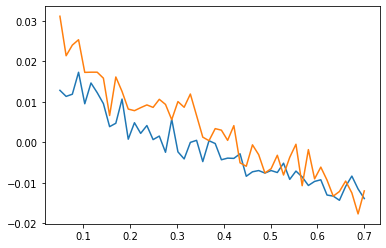

In [0]:
plt.plot(contam_levels, feat_a_score_avg_M[:,-2:])

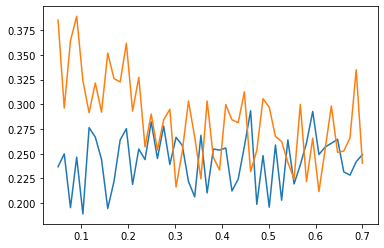

In [0]:
plt.plot(contam_levels, feat_a_score_norm_M[:,-2:])